In [12]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from bertopic import BERTopic
from tqdm.notebook import tqdm
from wordcloud import WordCloud, STOPWORDS

In [2]:
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
data_dir = os.path.join(parent_dir, "data")

In [3]:
df_combined = pd.read_csv(
    os.path.join(data_dir, "combined_final.csv"), encoding="utf-8"
)

In [4]:
df_combined.head()

,comment_id,author,date,comment,video_id,is_reply,parent_id,channel,genre,emoji
0,Ugz1ByKCNN-zcHnFDmt4AaABAg,Yuri Briceño,2023-11-12T19:03:39Z,It 39 s y good,lDK9QqIzhwk,False,NaN,bonjovi,metal,['❤️']
1,UgzEx14TY3TRXzYiY6F4AaABAg,leslie winchester,2023-11-12T18:12:49Z,2009 2011 six string in hock prayer still w...,lDK9QqIzhwk,False,NaN,bonjovi,metal,[]
2,UgyyXemVneI7UpYbunt4AaABAg,Jeff Packham,2023-11-12T14:25:41Z,no talk about club He man woman club Alfalfa ...,lDK9QqIzhwk,False,NaN,bonjovi,metal,"['🦜', '😎', '😂', '😎', '😂', '❤️', '🎉']"
3,UgxnQPStaiTWQqrwtfl4AaABAg,Reto Kaufmann,2023-11-12T13:37:51Z,Rock and metal radio station it quot shog...,lDK9QqIzhwk,False,NaN,bonjovi,metal,[]
4,UgylFha0XC_D4Amrmb94AaABAg,Thomas Schmutter,2023-11-12T10:35:46Z,From Bon Living on a Prayer,lDK9QqIzhwk,False,NaN,bonjovi,metal,['🎉']


In [5]:
df_combined.channel.value_counts()

channel
ariana_grande               109522
billie_eilish               109243
metallica                   108908
ed_sheeran                  108748
nicki_minaj                 108107
ledzeppelin                 106844
taylor_swift                106706
drake                       106126
queen                       105727
malone                      104308
thebeatles                  100249
kanye_west                   94638
eminem                       94626
olivia                       94216
ghost                        93452
pinkfloyd                    89895
kendrick_lamar               82626
systemofadown                78708
skrillex                     74433
chopin                       70830
beethoven                    58828
megadeth                     56142
bonjovi                      55353
mozart                       52715
slayer                       38353
kaleo                        32700
anthrax                      29420
bach                         10191
kirk fletche

In [6]:
df_combined.genre.value_counts()

genre
pop            632743
metal          443139
rock           419912
hip_hop_rap    391497
classical      192564
blues           51763
Name: count, dtype: int64

# Topic Modelling

In [14]:
def create_wordcloud(model: BERTopic, topic: int, mask: np.array, file_path: str):
    text = {word: value for word, value in model.get_topic(topic)}

    # create a custom colormap with only darker shades of magma
    # magma_colors = plt.cm.get_cmap("inferno")(np.linspace(0.2, 1, 256))
    magma_colors = plt.colormaps["inferno"](np.linspace(0.2, 1, 256))

    darker_magma = magma_colors[200:256]  # Adjust the index to control darkness

    # create a new colormap using only the darker shades of magma
    custom_cmap = plt.cm.colors.ListedColormap(darker_magma)

    wc = WordCloud(
        stopwords=STOPWORDS,
        mask=mask,
        background_color="rgba(255, 255, 255, 0)",  # transparent background
        mode="RGBA",
        max_words=1000,
        colormap=custom_cmap,
        width=mask.shape[1],
        height=mask.shape[0],
    )
    wc.generate_from_frequencies(text)

    if file_path.endswith(".png"):
        wc.to_file(file_path)
    elif file_path.endswith(".svg"):
        plt.axis("off")
        wordcloud_svg = wc.to_svg(embed_font=True)
        with open(file_path, "w+") as svg_file:
            svg_file.write(wordcloud_svg)

In [8]:
list(df_combined["genre"].unique())

['metal', 'blues', 'classical', 'pop', 'rock', 'hip_hop_rap', nan]

Topic Modelling: Genre:   0%|          | 0/2 [00:00<?, ?it/s]

Topic Modeling: Topic:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Jakub\AppData\Local\Temp\ipykernel_23252\4284282597.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  magma_colors = plt.cm.get_cmap("inferno")(np.linspace(0.2, 1, 256))


Topic Modeling: Topic:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Jakub\AppData\Local\Temp\ipykernel_23252\4284282597.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  magma_colors = plt.cm.get_cmap("inferno")(np.linspace(0.2, 1, 256))


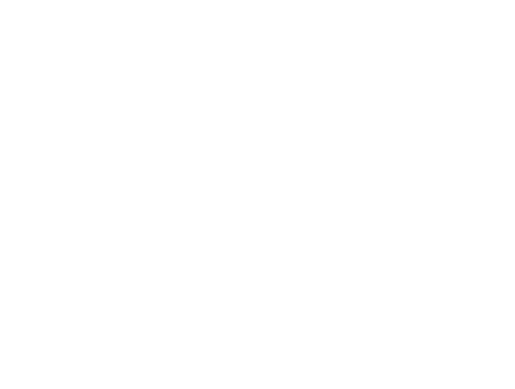

In [13]:
genre_shapes_dict = {
    # "metal": "metal_guitar.png",
    # "blues": "saxophone_blues.png",
    "classical": "classical_violin.png",
    # "pop": "pop_microphone.png",
    # "rock": "rock_guitar.png",
    "hip_hop_rap": "hip_hop_rap_rapper.png",
}

for genre_name, genre_shape_file in tqdm(
    genre_shapes_dict.items(), desc="Topic Modelling: Genre", leave=True
):
    output_folder = os.path.join(
        data_dir, "topic_modelling_in_shapes", "genres", genre_name
    )
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    model = BERTopic(language="english", top_n_words=100)

    texts = (
        df_combined[df_combined["genre"] == genre_name]
        .sample(frac=1)
        .head(100_000)["comment"]
        .values.tolist()
    )
    topics, probabilities = model.fit_transform(texts)

    mask = np.invert(
        np.array(
            Image.open(
                os.path.join(
                    data_dir, "topic_modelling_in_shapes", "shapes", genre_shape_file
                )
            )
        )
    )

    for topic_number in tqdm(range(5), desc="Topic Modeling: Topic", leave=False):
        create_wordcloud(
            model=model,
            topic=topic_number,
            mask=mask,
            file_path=os.path.join(
                output_folder, f"wordcloud_{topic_number}_{genre_name}.svg"
            ),
        )